In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

import windIO
import windOF as foam
import wind

In [3]:
# workDir = "D:/OneDrive - The University of Western Ontario/Documents/PhD/Thesis/01-revisitOfWindLoadEvaluation/01.02_Re_effect/Data/FFS/"
workDir = "D:/tempData_depot/simData_FFS/"
overwrite = True

# Pre-processing
### Separated shear layer

In [4]:
yLoc = 0
file = workDir+"probes.SSL.y_"+str(yLoc)

H = 0.08
xMin, xMax = 0.0, 2.0*H
zMin, zMax = 1.001*H, 2.0*H
d = 0.02*H
Nx, Nz = int(np.round((xMax-xMin)/d,0)), int(np.round((zMax-zMin)/d,0))

x, z = np.meshgrid(np.linspace(xMin, xMax, Nx), np.linspace(zMin, zMax, Nz))
x = x.flatten()
z = z.flatten()
y = np.ones_like(x)*yLoc

pts = np.column_stack((x,y,z))

print(f"Num in x: {Nx}, Num in z: {Nz}, Total: {Nx*Nz}")
# foam.writeProbeDict(file,pts,overwrite=overwrite)

Num in x: 100, Num in z: 50, Total: 5000


### Frontal BL

In [5]:
yLoc = 0
file = workDir+"probes.FBL.y_"+str(yLoc)

H = 0.08
xMin, xMax = 0.0001*H, 0.1*H
zMin, zMax = 0.0002, 1.0*H
d = 0.02*H
Nx, Nz = 50, int(np.round((zMax-zMin)/d,0))

X = -1.0*np.flip(np.logspace(np.log10(xMin), np.log10(xMax), Nx))

x, z = np.meshgrid(X, np.linspace(zMin, zMax, Nz))
x = x.flatten()
z = z.flatten()
y = np.ones_like(x)*yLoc

pts = np.column_stack((x,y,z))

print(f"Num in x: {Nx}, Num in z: {Nz}, Total: {Nx*Nz}")
# foam.writeProbeDict(file,pts,overwrite=overwrite)

Num in x: 50, Num in z: 50, Total: 2500


### Surface pressure

In [6]:
yLoc = 0
file = workDir+"probes.surfPres.y_"+str(yLoc)

H = 0.08
d = 0.02*H
xMax = 6.0*H
Nx, Nz = int(np.round(xMax/d,0)), int(np.round(H/d,0))

z1 = np.linspace(0.001, 0.99*H, Nz)
x1 = np.ones_like(z1)*-0.0001

x2 = np.linspace(0.0,xMax,Nx)
z2 = np.ones_like(x2)*H

x = np.append(x1,x2)
z = np.append(z1,z2)

y = np.ones_like(x)*yLoc

pts = np.column_stack((x,y,z))

print(f"Num in x: {Nx}, Num in z: {Nz}, Total: {Nx+Nz}")

# foam.writeProbeDict(file,pts,overwrite=overwrite,fields=['p'])

Num in x: 300, Num in z: 50, Total: 350


# Read and process data

In [7]:
caseName = "FFS_ABL_01a"
caseDir = workDir+caseName+"/"
prof_ABL_03 = foam.readVelProfile(caseDir=caseDir, probeName='probes.zProfile.x-0.3', H=H, trimTimeSegs=[[0,0.1]])
prof_ABL_03.name = "ABL (x=-0.3)"

caseName = "FFS_ABL_01a"
caseDir = workDir+caseName+"/"
prof_ABL_05 = foam.readVelProfile(caseDir=caseDir, probeName='probes.zProfile.x-0.5', H=H, trimTimeSegs=[[0,0.1]])
prof_ABL_05.name = "ABL (x=-0.5)"

caseName = "FFS_SBL_01"
caseDir = workDir+caseName+"/"
prof_SBL = foam.readVelProfile(caseDir=caseDir, probeName='probes.zProfile.x-0.3', H=H)
prof_SBL.name = "SBL"


Processing OpenFOAM case:	D:/tempData_depot/simData_FFS/FFS_ABL_01a/
Probe read from:		D:/tempData_depot/simData_FFS/FFS_ABL_01a//postProcessing/probes.zProfile.x-0.3
  >> Reading probe data ...
           Reading U from: D:/tempData_depot/simData_FFS/FFS_ABL_01a//postProcessing/probes.zProfile.x-0.3/0/U
                61 probes with 730 time steps (0.0 to 0.1458)
                No. of overlapping time steps with previously read data: 0
                Shape of data: (730, 61, 3)
           Reading U from: D:/tempData_depot/simData_FFS/FFS_ABL_01a//postProcessing/probes.zProfile.x-0.3/0.145/U
                61 probes with 613 time steps (0.145 to 0.2674)
                No. of overlapping time steps with previously read data: 5
                Shape of data: (613, 61, 3)
           Reading U from: D:/tempData_depot/simData_FFS/FFS_ABL_01a//postProcessing/probes.zProfile.x-0.3/0.267/U
                61 probes with 749 time steps (0.267 to 0.4166)
                No. of overlapping t

4.376605953424502


<function windOF.meshSizeFromCutoffFreq(nc, Suu, Svv, Sww)>

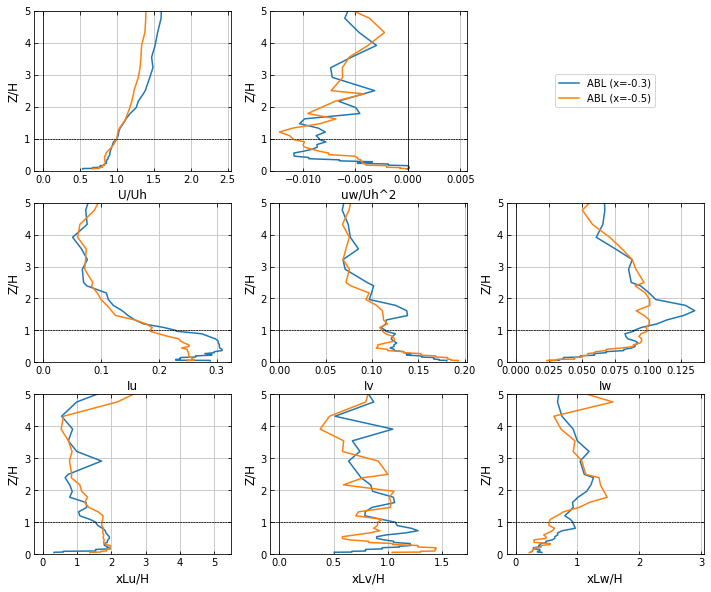

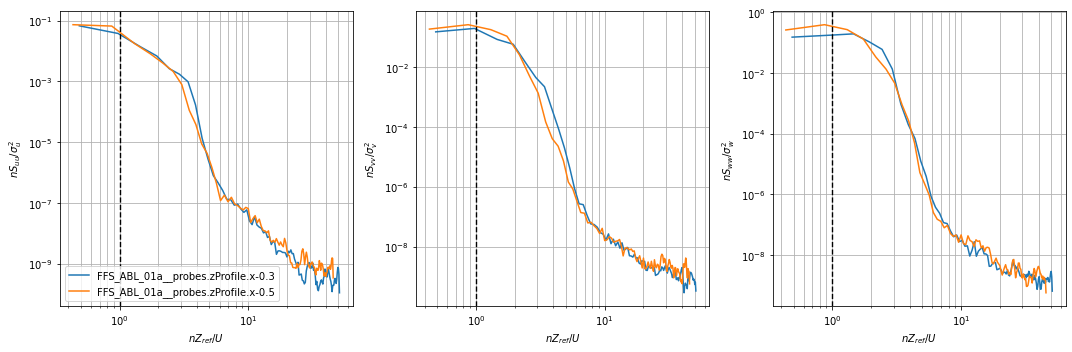

In [8]:
profs = wind.Profiles([prof_ABL_03, prof_ABL_05])
profs.plotProfile_basic2(yLimits=[0,5])
profs.plotSpectra(normU='sigUi')

print(prof_ABL_05.Uh)
foam.meshSizeFromCutoffFreq

(61, 1682)
(1682,)


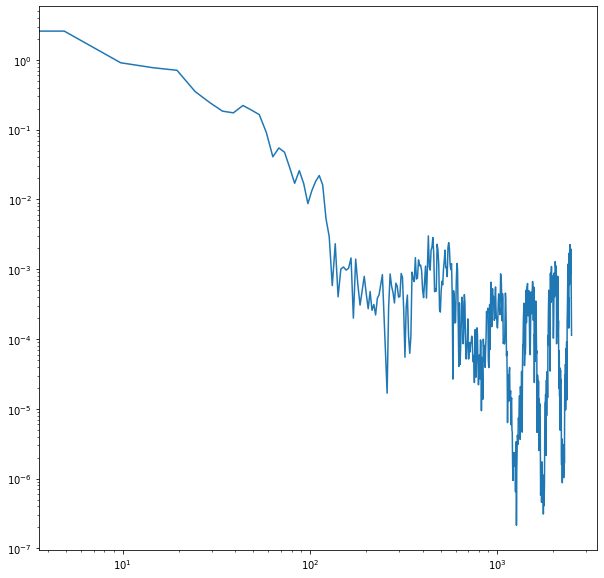

ValueError: x and y must have same first dimension, but have shapes (1682,) and (1681,)

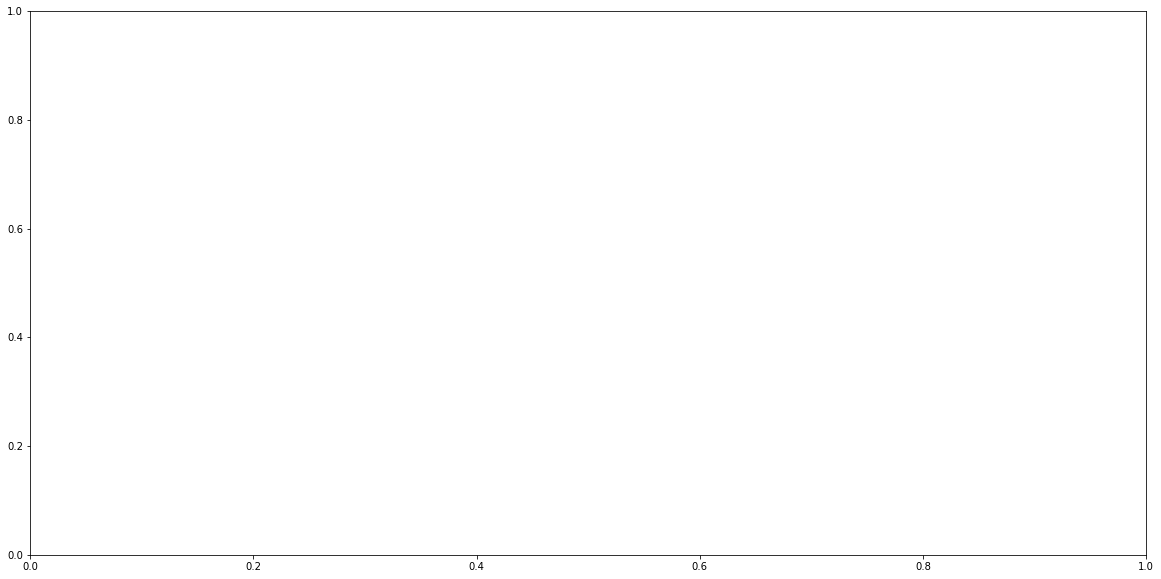

In [9]:
import scipy.signal as signal

print(prof_ABL_03.pOfT.shape)
print(prof_ABL_03.t.shape)

p = prof_ABL_03.pOfT[40,:-1]
freq, Sp = signal.welch(p-np.mean(p), fs=1/prof_ABL_03.dt, nperseg=1024, noverlap=512, detrend=False, scaling='density')

# highpass filter the pressure at 100Hz
p_new = signal.filtfilt(b=signal.butter(3, 100/(1/prof_ABL_03.dt), btype='high', output='ba')[0], a=signal.butter(3, 100/(1/prof_ABL_03.dt), btype='high', output='ba')[1], x=p-np.mean(p))
p_cleaned = p - p_new

plt.figure(figsize=(10,10))
plt.loglog(freq, Sp)
plt.show()

plt.figure(figsize=(20,10))
plt.plot(prof_ABL_03.t, prof_ABL_03.pOfT[60,:-1]-p_new, label='60')
plt.plot(prof_ABL_03.t, prof_ABL_03.pOfT[50,:-1]-p_new, label='50')
plt.plot(prof_ABL_03.t, prof_ABL_03.pOfT[40,:-1]-p_new, label='40')
plt.plot(prof_ABL_03.t, prof_ABL_03.pOfT[30,:-1]-p_new, label='30')
plt.plot(prof_ABL_03.t, prof_ABL_03.pOfT[20,:-1]-p_new, label='20')
plt.plot(prof_ABL_03.t, prof_ABL_03.pOfT[10,:-1]-p_new, label='10')
# plt.plot(prof_ABL_03.t, p, label='unfiltered')
# plt.plot(prof_ABL_03.t, p_new, label='filtered')
# plt.plot(prof_ABL_03.t, p_cleaned, label='cleaned')
plt.legend()
plt.xlim([1,1.1])
plt.show()

In [42]:
# caseName = "FFS_ABL_inf"
# caseDir = workDir+caseName+"/"
# # pressure_surf_i,probes_surf_i,time_surf_i, = foam.readSurfacePressure(caseDir=caseDir, probeName='probes.zProfile.x0.0', trimTimeSegs=[[0,0.5]])
# prof_inf = foam.readVelProfile(caseDir=caseDir, probeName='probes.zProfile.x0.0', H=H, trimTimeSegs=[[0,0.5]])

# caseName = "FFS_ABL_01"
# caseDir = workDir+caseName+"/"
# # pressure_surf,probes_surf,time_surf = foam.readSurfacePressure(caseDir=caseDir, probeName='probes.surfPres.y_0')
# prof_01 = foam.readVelProfile(caseDir=caseDir, probeName='probes.zProfile.x-0.3', H=H, trimTimeSegs=[[0,0.2]])
# pres_01,pts_01,ptime_01, = foam.readSurfacePressure(caseDir=caseDir, probeName='probes.surfPres.y_0', trimTimeSegs=[[0,0.2]])

# caseName = "FFS_ABL_01__old"
# caseDir = workDir+caseName+"/"
# # pressure_surf,probes_surf,time_surf = foam.readSurfacePressure(caseDir=caseDir, probeName='probes.surfPres.y_0')
# prof_01o = foam.readVelProfile(caseDir=caseDir, probeName='probes.zProfile.x-0.3', H=H, trimTimeSegs=[[0,0.2]])
# pres_01o,pts_01o,ptime_01o, = foam.readSurfacePressure(caseDir=caseDir, probeName='probes.surfPres.y_0', trimTimeSegs=[[0,0.2]])

# caseName = "FFS_SBL_01"
# caseDir = workDir+caseName+"/"
# prof_SBL = foam.readVelProfile(caseDir=caseDir, probeName='probes.zProfile.x-0.3', H=H)

# caseName = "FFS_ABL_01b"
# caseDir = workDir+caseName+"/"
# # pressure_surf_a,probes_surf_a,time_surf_a, = foam.readSurfacePressure(caseDir=caseDir, probeName='probes.surfPres.y_0', trimTimeSegs=[[0,0.05]])
# prof_b = foam.readVelProfile(caseDir=caseDir, probeName='probes.zProfile.x-0.3', H=H, trimTimeSegs=[[0,0.05]])
# # pressure_surf_ap,probes_surf_ap,time_surf_ap, = foam.readSurfacePressure(caseDir=caseDir, probeName='probes.zProfile.x-0.3', trimTimeSegs=[[0,0.05]])

# caseName = "FFS_ABL_01c"
# caseDir = workDir+caseName+"/"
# prof_c = foam.readVelProfile(caseDir=caseDir, probeName='probes.zProfile.x-0.3', H=H, trimTimeSegs=[[0,0.2]])

# caseName = "FFS_ABL_01d"
# caseDir = workDir+caseName+"/"
# prof_d = foam.readVelProfile(caseDir=caseDir, probeName='probes.zProfile.x-0.3', H=H, trimTimeSegs=[[0,0.2]])
# pres_d,pts_d,ptime_d, = foam.readSurfacePressure(caseDir=caseDir, probeName='probes.surfPres.y_0', trimTimeSegs=[[0,0.2]])

# caseName = "FFS_ABL_01e"
# caseDir = workDir+caseName+"/"
# prof_e = foam.readVelProfile(caseDir=caseDir, probeName='probes.zProfile.x-0.3', H=H, trimTimeSegs=[[0,0.2]])

# caseName = "FFS_ABL_01f"
# caseDir = workDir+caseName+"/"
# prof_f = foam.readVelProfile(caseDir=caseDir, probeName='probes.zProfile.x-0.3', H=H, trimTimeSegs=[[0,0.2]])

# caseName = "FFS_ABL_01g"
# caseDir = workDir+caseName+"/"
# prof_g = foam.readVelProfile(caseDir=caseDir, probeName='probes.zProfile.x-0.3', H=H, trimTimeSegs=[[0,0.2]])
# pres_g,pts_g,ptime_g, = foam.readSurfacePressure(caseDir=caseDir, probeName='probes.surfPres.y_0', trimTimeSegs=[[0,0.2]])

# caseName = "FFS_ABL_01h"
# caseDir = workDir+caseName+"/"
# prof_h = foam.readVelProfile(caseDir=caseDir, probeName='probes.zProfile.x-0.3', H=H, trimTimeSegs=[[0,0.2]])
# pres_h,pts_h,ptime_h, = foam.readSurfacePressure(caseDir=caseDir, probeName='probes.surfPres.y_0', trimTimeSegs=[[0,0.2]])

# caseName = "FFS_ABL_01i"
# caseDir = workDir+caseName+"/"
# prof_i = foam.readVelProfile(caseDir=caseDir, probeName='probes.zProfile.x-0.3', H=H, trimTimeSegs=[[0,0.02]])
# pres_i,pts_i,ptime_i, = foam.readSurfacePressure(caseDir=caseDir, probeName='probes.surfPres.y_0', trimTimeSegs=[[0,0.02]])

caseName = "FFS_ABL_01j"
caseDir = workDir+caseName+"/"
prof_j = foam.readVelProfile(caseDir=caseDir, probeName='probes.zProfile.x-0.3', H=H, trimTimeSegs=[[0,0.02]])
pres_j,pts_j,ptime_j, = foam.readSurfacePressure(caseDir=caseDir, probeName='probes.surfPres.y_0', trimTimeSegs=[[0,0.02]])

Processing OpenFOAM case:	D:/tempData_depot/simData_FFS/FFS_ABL_01j/
Probe read from:		D:/tempData_depot/simData_FFS/FFS_ABL_01j//postProcessing/probes.zProfile.x-0.3
  >> Reading probe data ...
           Reading U from: D:/tempData_depot/simData_FFS/FFS_ABL_01j//postProcessing/probes.zProfile.x-0.3/0/U
                61 probes with 5725 time steps (0.0 to 1.1448)
                No. of overlapping time steps with previously read data: 0
                Shape of data: (5725, 61, 3)
           Reading U from: D:/tempData_depot/simData_FFS/FFS_ABL_01j//postProcessing/probes.zProfile.x-0.3/1.144/U
                61 probes with 504 time steps (1.144 to 1.2446)
                No. of overlapping time steps with previously read data: 5
                Shape of data: (504, 61, 3)
           Reading U from: D:/tempData_depot/simData_FFS/FFS_ABL_01j//postProcessing/probes.zProfile.x-0.3/1.244/U
                61 probes with 4296 time steps (1.244 to 2.103)
                No. of overlapping

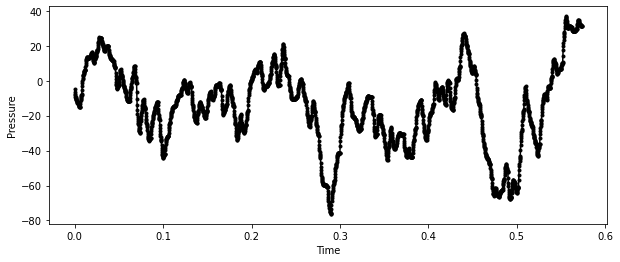

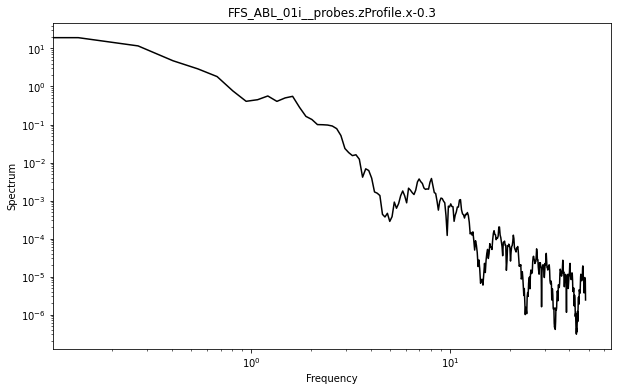

In [44]:
profile = prof_i
pres,pts,ptime = pres_i, pts_i, ptime_i

if True:
    p = profile.pOfT[40,:]
    t = profile.t
    dt = profile.dt

    # _ = profile.plotProfile_basic2()
    # profile.SpectH.plot(yLimits=[1e-5,1e-2])
else:
    idx = 50
    print(f"Point coordinates: {pts[idx,:]}")
    t = ptime
    dt = t[1]-t[0]

    idxForProf = np.where(np.isin(np.round(profile.t,5), np.round(t,5)))[0]
    idxForPres = np.where(np.isin(np.round(t,5), np.round(profile.t,5)))[0]
    pOrig = pres[idxForPres,idx]
    p = pOrig #- np.mean(profile.pOfT[30:-4, idxForProf], axis=0)
    t = t[idxForPres]

freq, Sp = wind.psd(p, 1/dt, 4)


plt.figure(figsize=(10,4))
plt.plot(t, p, '.-k')
# plt.plot(t, pOrig, '-b')
# plt.plot(profile.t, profile.pOfT[40,:], '-r')
# plt.xlim([0.44,0.46])
plt.xlabel('Time')
plt.ylabel('Pressure')
# plt.title(profile.name+f" [{pts[idx,0]}, {pts[idx,1]}, {pts[idx,2]}]")
plt.show()

plt.figure(figsize=(10,6))
plt.loglog(freq*profile.H/profile.Uh, Sp, '-k')
plt.xlabel('Frequency')
plt.ylabel('Spectrum')
plt.title(profile.name)
plt.show()

In [45]:
print(prof_i.T)

0.5738
